In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [3]:

dirname = ''
train_path = os.path.join(dirname, 'OCT2017/train')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')



In [71]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 4, idx+1)

        img = plt.imread(img_path,0)
        img_eq = cv2.equalizeHist(img)

        plt.imshow(img)

    plt.tight_layout()

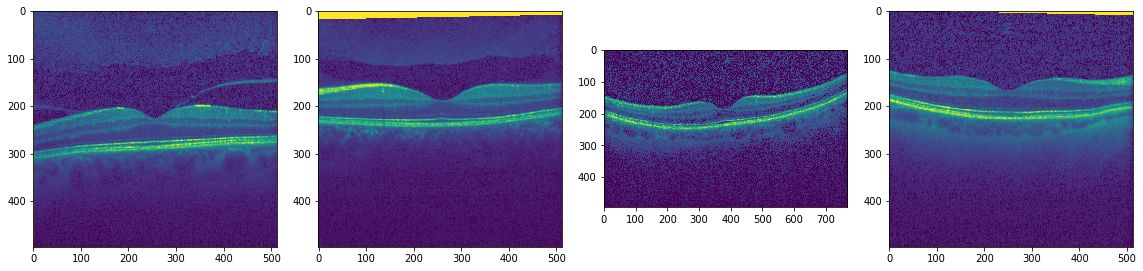

In [72]:
plot_imgs(test_normal_pth)

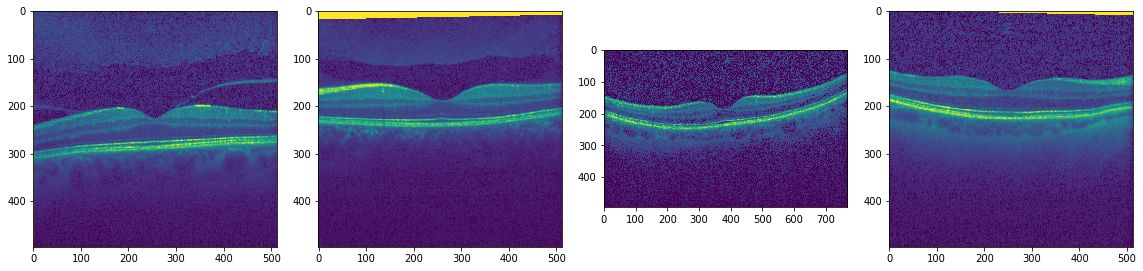

In [67]:
plot_imgs(test_normal_pth)

In [7]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [8]:
Images_details(train_normal_pth)
Images_details(train_dme_pth)
Images_details(train_drusen_pth)
Images_details(train_cnv_pth)



 ====== Images in:  OCT2017/train\NORMAL
images_count:	26315
min_width:	384
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DME
images_count:	11348
min_width:	512
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DRUSEN
images_count:	8616
min_width:	512
max_width:	768
min_height:	496
max_height:	496
 ====== Images in:  OCT2017/train\CNV
images_count:	37205
min_width:	384
max_width:	1536
min_height:	496
max_height:	496


In [9]:
input_path = "OCT2017/"

for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 242, DME images: 242, DRUSEN images: 242, CNV images: 242
val, Normal images: 8, DME images: 8, DRUSEN images: 8, CNV images: 8


In [63]:
from matplotlib import pyplot as plt

train_datagen = ImageDataGenerator(
        #rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        
        zoom_range = 0.3,
        horizontal_flip = True,
        preprocessing_function = augment 
    )




for x_batch, y_batch in train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (160, 160), 
    batch_size = 32, 
    class_mode = 'categorical', 
    shuffle=True) :
    # Show the first 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(160, 160, 3))
    # show the plot
    pyplot.show()
    break

Found 83484 images belonging to 4 classes.


ValueError: Got dtype 'float32' in augmenter 'UnnamedAllChannelsHistogramEqualization' (class 'AllChannelsHistogramEqualization'), which is a forbidden dtype (bool, uint16, uint32, uint64, uint128, uint256, int8, int16, int32, int64, int128, int256, float16, float32, float64, float96, float128, float256).

In [73]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Invert(0.2),
        iaa.Rotate((-45, 45)),
        iaa.GaussianBlur(sigma=(0, 3.0)) 
        #iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization())
        # blur images with a sigma of 0 to 3.0
    ])
def augment(img):
        seq_det = seq.to_deterministic()
        
        aug_image = seq_det.augment_image(img)
        return aug_image
    
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True,
        preprocessing_function = augment )
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=test_path, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = np.dstack([img, img, img])
            
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/DME/':
                label = 1
            elif cond=='/DRUSEN/':
                label = 2
            elif cond=='/CNV/':
                label = 3
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [41]:
counter = 0
for cond in ['/NORMAL/']:
        for img in (os.listdir(test_path + cond)):
            
            img = plt.imread(test_path + cond + img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (512, 512))
            #img = np.dstack([img, img, img])
            #img = img.astype('float32') / 255
            

            #img_eq = cv2.equalizeHist(grayimg)
            break

aug_img = augment(img)
plt.imshow(img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(aug_img)

error: OpenCV(4.2.0) d:\bld\libopencv_1579753492509\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x03f6a1c9::Set<1,-1,-1>,struct cv::impl::A0x03f6a1c9::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [77]:
PARAMS = {'img_dims': 160,
          'epochs': 35,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }


In [18]:
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])


Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [ ]:


# Constant to control how often we print when training models
print_every = 100
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPool2D((3, 3), strides=(2, 2))(X)


# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
# Stage 3
X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4
X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5
X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

# AVGPOOL
X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
X = Flatten()(X)
X = Dense(4, activation='softmax')(X)
# Output layer
output = Dense(units=4, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

# Callbacks

Using device:  /device:GPU:0


In [75]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 80, 80, 16)        6416      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 80, 16)        6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 16)        0   

In [78]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
           
           validation_data=test_gen, 
           validation_steps=test_gen.samples // PARAMS['batch_size'])
           #callbacks=[checkpoint, lr_reduce])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2608 steps, validate for 30 steps
Epoch 1/35
2608/2608 [==============================] - 748s 287ms/step - loss: 1.2311 - accuracy: 0.4456 - val_loss: 1.5637 - val_accuracy: 0.2510
Epoch 2/35
2608/2608 [==============================] - 744s 285ms/step - loss: 1.2307 - accuracy: 0.4457 - val_loss: 1.5479 - val_accuracy: 0.2510
Epoch 3/35
2608/2608 [==============================] - 8246s 3s/step - loss: 1.2304 - accuracy: 0.4457 - val_loss: 1.5510 - val_accuracy: 0.2510
Epoch 4/35
2608/2608 [==============================] - 743s 285ms/step - loss: 1.2303 - accuracy: 0.4456 - val_loss: 1.5550 - val_accuracy: 0.2510
Epoch 5/35
2608/2608 [==============================] - 743s 285ms/step - loss: 1.2304 - accuracy: 0.4457 - val_loss: 1.5583 - val_accuracy: 0.2510
Epoch 6/35
2608/2608 [==============================] - 742s 285ms/step - loss: 1.2302 - accuracy: 0.4457 - val_loss: 1.5398 - val_accuracy: 0.2510
Epoch 7/35
2608/2608

KeyboardInterrupt: 

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.e